# EfficientDet for Edge-Aware Image Segmentation

In this task - one should implement a part of the one of the state-of-the-art NN architecture for dense predictions - [EfficientDet](https://arxiv.org/pdf/1911.09070.pdf) - called the BiFPN feature combinator. Then one should use the features from the FPN as an input to two heads: one for an person segmentation (single class) and other for an edge detection. This network should be trained on the PennFundan dataset with traditional augmentations.

## Dataset and augmentations (2pt)

Our dataset is a modified [PennFundan](https://www.cis.upenn.edu/~jshi/ped_html/) dataset (known from a previous task). For each image $I$ in this dataset and its pedestrians masks $M^{I}_{1}, ... M^{I}_{n}$ we generate a dataset consisting of $n$ new images and their corresponding masks (both person and edge ones): $\{(DI^{I}_{1} , DM^{I}_{1}, DE^{I}_{1}),  ... (DI^{I}_{n}, DM^{I}_{n}, DE^{I}_{n})\}$. For each $i = 1, .. ,n$, $DI^{I}_{i}$ is obtained by first extending the minimal bounding box encircling a mask $M^{I}_{i}$ by 12 pixels (if possible, if not - by a maximal possible number of pixels) in each direction and then resizing it to a square of size $(128, 128)$. Mask $DM^{I}_{i}$ is obtained in the same manner and it is downscaled to the size of $(64, 64)$. For each mask - its edge mask $DE^{I}$ is computed as a mask for those pixels $p$ in the person mask for which there exist two pixels $p_m, p_b$ distant from $p$ by at most 2 in $L^{\inf}$ distance on the image for which $p_m$ belongs to a person mask and $p_b$ does not.

Your task is to implement a function `get_edge_of_mask` that extracts the edge of the mask (1pt).

**Hint**: the edge mask may be easily computed using convolution.

**Clarification**:

$$L^{\inf}((x_1^1, x_2^1), (x_1^2, x_2^2) = \max_{i = 1, 2} |x_i^1 - x_i^2|.$$

One should also implement a set of at least three standard image / mask augmentations (e.g., flips, rotations, etc.). They should be applied to image, person mask and edge mask in a consistent manner (1pt).

##BiFPN (3pts)

One should implement a BIFPN module with a pixel-wise weighted feature fusion as described in section 3.3 of [this](https://arxiv.org/pdf/1911.09070.pdf) paper (3pts). The fusion weighting function (e.g., softmax, unbounded, etc.) is to be decided by the student.

**Hint**: if a model explodes, try to use a bounded activation functions. Using pixel-wise fusion strategy might also cause the training to have a rough start - so wait a few epochs before you decide to stop the training.

## Full Model (1pts)

A full model should consist of:
- an [EfficientNet-B0](https://arxiv.org/abs/1905.11946) backbone,
- a feature fusion consisting of multiple consecutive BiFPN blocks (number of blocks is to be decided by the student, number between 2 and 4 is suggested),
- a final feature merging (e.g., a standard feature pyramid) that is fed to two classification heads of size $(64, 64)$ - one for pixel-wise person mask prediction and other - for edge prediction.

**Hint**: Feature merging might accept as an input not only output from the final BiFPN block. It might be useful to reuse outputs from the intermediate BiFPN blocks or even outputs from the backbone itself.

## Training (4pts)

You should train your model on tuples $\{(DI^{I}_{1} , DM^{I}_{1}, DE^{I}_{1}),  ... (DI^{I}_{n}, DM^{I}_{n}, DE^{I}_{n})\}$ obtained from a first ($70\%$) of images validate on the following $15\%$ and test on the rest. The loss function should be a binary crossentropy. The full loss should be equal to:

$$Loss = MaskLossBCE + \lambda EdgeLossBCE,$$

Train your model for different values of $\lambda < 0.1$ (test at least 3 different positive values and case when $\lambda = 0$) and compare the results using Person IOU metric on a mask prediction and Edge IOU on edge prediction tasks. At least one of your models should exceed $0.7$ of Person IOU for a mask prediction task (1pt). These results should be presented in a form of a short report (2pts).

**Hint:** IOU score is dependent on a threshold applied to a continuos prediction of your model. A proper calibration on this threshold might help you to achieve better results. Be careful however - not to overfit to your data.

The report should include:
- analysis of model results vs different values of $\lambda$. This comparison might be performed on a single, selected model architecture. For all of these models - show the relation between Edge IOU and Person IOU values, on both train and test datasets (or any other if you split the train into appropriate subsets) (1pt),
- analysis if Edge IOU visually correlates with a mask prediction and edge prediction quality by a visual analysis of the 5 best and the 5 worst examples w.r.t. to this metric, (1pt).

The final (1pt) will be awarded by a proper implementation of a loss function and appropriate IOU metrics.

Good luck!

### Dataset preparation

In [ ]:
# Dataset downloading:
!wget https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip

# Dataset unzipping:
!unzip PennFudanPed.zip

# Install
!pip install efficientnet_pytorch
!pip install clearml

In [1]:
DATASET_PATH = "./PennFudanPed"

In [2]:
import numpy as np
import os


TRAIN_PERCENTAGE = 0.7
VAL_PERCENTAGE = 0.15
TEST_PERCENTAGE = 0.15


imgs_filenames = list(sorted(os.listdir(os.path.join(DATASET_PATH, "PNGImages"))))
masks_filenames = list(sorted(os.listdir(os.path.join(DATASET_PATH, "PedMasks"))))

imgs_paths = [
    os.path.join(DATASET_PATH, "PNGImages", img_filename)
    for img_filename in imgs_filenames
]

masks_paths = [
    os.path.join(DATASET_PATH, "PedMasks", mask_filename)
    for mask_filename in masks_filenames
]

train_split_index = int(len(imgs_paths) * TRAIN_PERCENTAGE)
val_split_index = int(len(imgs_paths) * (TRAIN_PERCENTAGE + VAL_PERCENTAGE))

train_imgs_paths = imgs_paths[:train_split_index]
train_masks_paths = masks_paths[:train_split_index]

val_imgs_paths = imgs_paths[train_split_index:val_split_index]
val_masks_paths = masks_paths[train_split_index:val_split_index:]

test_imgs_paths = imgs_paths[val_split_index:]
test_masks_paths = masks_paths[val_split_index:]

In [3]:
from PIL import Image
import torch


SINGLE_IMAGE_PIXEL_EXTENSION = 12
EDGE_WINDOW_SIZE = 2


import torch
import torch.nn as nn

def get_edge_of_mask(mask, window_size):
    mask = torch.as_tensor(mask).view(1, mask.shape[0], mask.shape[1]).float()
    kernel_size = 2 * window_size + 1

    weight = torch.ones(kernel_size, kernel_size)
    weight[window_size, window_size] = -(kernel_size ** 2 - 1)
    weight = weight.unsqueeze(0).unsqueeze(0)
    conv = nn.Conv2d(1, 1, kernel_size=kernel_size, padding=window_size, bias=False)
    conv.weight = nn.Parameter(weight)

    edges = conv(mask)
    edges = edges.detach().numpy().squeeze()
    edges[edges > 0] = 0
    edges[edges < 0] = 1
    return edges.astype(bool)


def load_images_masks_and_edges_from_path(
    img_path, 
    mask_path,
    pixel_extension=SINGLE_IMAGE_PIXEL_EXTENSION,
    edge_window_size=EDGE_WINDOW_SIZE,
    ):
    # Loading image and mask
    mask = np.array(Image.open(mask_path))
    image = np.array(Image.open(img_path))
    obj_ids = np.unique(mask)
    
    # Masks extraction
    masks = mask == obj_ids[:, None, None]
    img_size = masks[0].shape

    # get bounding box coordinates for each mask
    num_objs = len(obj_ids)
    boxes = []
    extended_boxes = []
    extended_images = []
    extended_masks = []
    extended_edges = []
    for i in range(1, num_objs):
        pos = np.where(masks[i])
        xmin = np.min(pos[1]) 
        xmax = np.max(pos[1])
        ymin = np.min(pos[0])
        ymax = np.max(pos[0])
        boxes.append([xmin, ymin, xmax, ymax])
        x_min_ex = max(xmin - pixel_extension, 0)
        x_max_ex = min(xmax + pixel_extension, img_size[1])
        y_min_ex = max(ymin - pixel_extension, 0)
        y_max_ex = min(ymax + pixel_extension, img_size[0])
        extended_boxes.append([x_min_ex, y_min_ex, x_max_ex, y_max_ex])
        extended_images.append(image[y_min_ex:y_max_ex, x_min_ex:x_max_ex])
        new_mask = masks[i, y_min_ex:y_max_ex, x_min_ex:x_max_ex]
        extended_masks.append(new_mask)
        # Application of get_edge_of_mask:
        extended_edges.append(get_edge_of_mask(new_mask, edge_window_size))

    return extended_boxes, extended_images, extended_masks, extended_edges

Visualizing example image, mask and edges:

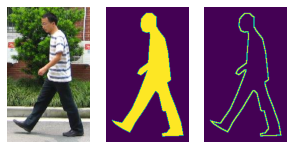

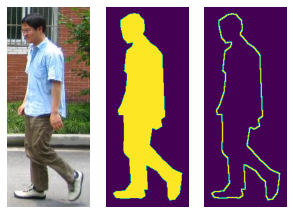

In [4]:
import matplotlib.pyplot as plt


extended_boxes, extended_images, extended_masks, extended_edges = load_images_masks_and_edges_from_path(
    train_imgs_paths[0], train_masks_paths[0], 12
)


for image, mask, edge in zip(extended_images, extended_masks, extended_edges):
    plt.figure(figsize=(5, 15))
    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.imshow(mask)
    plt.axis('off')
    plt.subplot(1, 3, 3)
    plt.imshow(edge)
    plt.axis('off')
    plt.show()

Dataset loading:

In [5]:
def load_data_from_paths(img_paths, mask_paths):
    extended_boxes, extended_images, extended_masks, extended_edges = [], [], [], []
    for img_path, mask_path in zip(img_paths, mask_paths):
        new_boxes, new_images, new_masks, new_edges = load_images_masks_and_edges_from_path(
            img_path, mask_path,
        )
        extended_boxes.extend(new_boxes)
        extended_images.extend(new_images)
        extended_masks.extend(new_masks)
        extended_edges.extend(new_edges)
    return extended_boxes, extended_images, extended_masks, extended_edges


train_boxes, train_images, train_masks, train_edges = load_data_from_paths(
    img_paths=train_imgs_paths,
    mask_paths=train_masks_paths,
)


val_boxes, val_images, val_masks, val_edges = load_data_from_paths(
    img_paths=val_imgs_paths,
    mask_paths=val_masks_paths,
)


test_boxes, test_images, test_masks, test_edges = load_data_from_paths(
    img_paths=test_imgs_paths,
    mask_paths=test_masks_paths,
)

Dataset transformations:

In [6]:
from typing import List, Tuple, Dict, Optional, Union

import torch
import torchvision
from torch import nn, Tensor
from torchvision.transforms import functional as F
from torchvision.transforms import transforms as T, InterpolationMode


class Compose:
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, mask, edge):
        for t in self.transforms:
            image, mask, edge = t(image, mask, edge)
        return image, mask, edge


# Implement a Random Horizontal Flip on triple (image, mask, edge)
class RandomHorizontalFlip(T.RandomHorizontalFlip):
    def forward(
            self, 
            image: Tensor,
            mask: Tensor, 
            edge: Tensor,
    ) -> Tuple[Tensor, Tensor, Tensor]:
        if torch.rand(1) < self.p:
            image = F.hflip(image)
            mask = F.hflip(mask)
            edge = F.hflip(edge)
        return (image, mask, edge)


class RandomRotation(nn.Module):
    def __init__(self, degrees):
        super().__init__()
        self.degrees = (-degrees, degrees)

    def forward(
            self, 
            image: Tensor,
            mask: Tensor, 
            edge: Tensor,
    ) -> Tuple[Tensor, Tensor, Tensor]:
        degrees_ = torch.tensor(0.0).uniform_(*self.degrees).item()

        image = image.view([1] + list(image.shape))
        mask = mask.view([1, 1] + list(mask.shape))
        edge = edge.view([1, 1] + list(edge.shape))
        image = F.rotate(image, degrees_).squeeze()
        mask = F.rotate(mask, degrees_).squeeze()
        edge = F.rotate(edge, degrees_).squeeze()
        return (image, mask, edge)


class ColorJitter(nn.Module):
    def __init__(self):
        super().__init__()
        contrast: Tuple[float] = (0.5, 1.5)
        saturation: Tuple[float] = (0.5, 1.5)
        hue: Tuple[float] = (-0.05, 0.05)
        brightness: Tuple[float] = (0.875, 1.125)
        self.jitter = T.ColorJitter(contrast=contrast, saturation=saturation, 
                                    hue=hue, brightness=brightness)

    def forward(
            self, 
            image: Tensor,
            mask: Tensor, 
            edge: Tensor,
    ) -> Tuple[Tensor, Tensor, Tensor]:
        image = image.view([1] + list(image.shape))
        image = self.jitter(image).squeeze()
        return (image, mask, edge)


class ConvertImageDtype(nn.Module):
    def __init__(self, dtype: torch.dtype) -> None:
        super().__init__()
        self.dtype = dtype

    def forward(
            self, 
            image: Tensor,
            mask: Tensor, 
            edge: Tensor,
    ) -> Tuple[Tensor, Tensor, Tensor]:
        image = F.convert_image_dtype(image, self.dtype)
        return image, mask.to(torch.float32), edge.to(torch.float32)


# EfficientNet Normalization function
class Normalize(torch.nn.Module):
    def __init__(self):
        super(Normalize, self).__init__()
        self.normalizer = torchvision.transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )

    def forward(
        self, 
        image: Tensor,
        mask: Tensor, 
        edge: Tensor,
    ) -> Tuple[Tensor, Tensor, Tensor]:
        return self.normalizer(image), mask, edge


class ToNumpy(torch.nn.Module):
    def __init__(self):
        super(ToNumpy, self).__init__()

    def forward(
        self, 
        image: Tensor,
        mask: Tensor, 
        edge: Tensor,
    ) -> Tuple[Tensor, Tensor, Tensor]:
        return (
            torch.from_numpy(image.astype('float32').transpose([2, 0, 1])) / 255.0,
            torch.from_numpy(mask),
            torch.from_numpy(edge),
        )


# Implement resizing image -> (128, 128), edge -> (64, 64), mask -> (64, 64)
class Upsample(torch.nn.Module):
    def forward(
        self, 
        image: Tensor,
        mask: Tensor, 
        edge: Tensor,
    ) -> Tuple[Tensor, Tensor, Tensor]:
        image = image.view([1] + list(image.shape))
        mask = mask.view([1, 1] + list(mask.shape))
        image = F.resize(image, (128, 128)).squeeze()
        mask = F.resize(mask, (64, 64)).squeeze()
        mask[mask > 0] = 1.0
        edge = get_edge_of_mask(mask, EDGE_WINDOW_SIZE)
        return (image, mask, edge)

Torch Datasets creation:

In [7]:
class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(
        self,
        images,
        masks,
        edges,
        transforms,
    ):
        self.transforms = transforms
        self.images = images
        self.masks = masks
        self.edges = edges

    def __getitem__(self, idx):
        return self.transforms(
            self.images[idx],
            self.masks[idx], 
            self.edges[idx],
        )

    def __len__(self):
        return len(self.images)

# Extend this list with at least two additional transformations
train_transform = Compose(
    [
        ToNumpy(),
        ConvertImageDtype(torch.float32),
        Normalize(),
        RandomHorizontalFlip(),
        RandomRotation(30),
        ColorJitter(),
        Upsample(),
    ]
)

val_transform = Compose(
    [
        ToNumpy(),
        ConvertImageDtype(torch.float32),
        Normalize(),
        Upsample(),
    ]
)

# This should remain the same.
test_transform = Compose(
    [
        ToNumpy(),
        ConvertImageDtype(torch.float32),
        Normalize(),
        Upsample(),
    ]
)


train_dataset = PennFudanDataset(
    images=train_images,
    masks=train_masks,
    edges=train_edges,
    transforms=train_transform,
)

val_dataset = PennFudanDataset(
    images=val_images,
    masks=val_masks,
    edges=val_edges,
    transforms=val_transform,
)

test_dataset = PennFudanDataset(
    images=test_images,
    masks=test_masks,
    edges=test_edges,
    transforms=test_transform,
)

IOU implementation:

In [8]:
def iou(y_true, y_pred, threshold=0.0):
    ious = torch.sum(torch.logical_and(y_true, y_pred >= threshold), dim=[1, 2]) \
        / torch.sum(torch.logical_or(y_true, y_pred >= threshold), dim=[1, 2])
    return torch.mean(ious)


# Return an array of ious instead of taking a mean.
def ious(y_true, y_pred, threshold=0.0):
    ious = torch.sum(torch.logical_and(y_true, y_pred >= threshold), dim=[1, 2]) \
        / torch.sum(torch.logical_or(y_true, y_pred >= threshold), dim=[1, 2])

    return ious

# Note on using `efficientnet_pytorch`

The code below shows how to use `efficientnet_pytorch` to extract intermediate layers from an `efficient_net_model`:

```
!pip install efficientnet_pytorch


from efficientnet_pytorch import EfficientNet

EFFICIENT_NET_MODEL_NAME = 'efficientnet-b0'
model = EfficientNet.from_pretrained(EFFICIENT_NET_MODEL_NAME)
test_tensor = torch.tensor(np.random.normal(size=(1, 3, 128, 128)).astype('float32'))
intermediate_outputs_dict = model.extract_endpoints(test_tensor)
ilustrating_dict = {
    key_: intermediate_outputs_dict[key_].shape
    for key_ in intermediate_outputs_dict
}
print(ilustrating_dict)

Output:
{
  'reduction_1': torch.Size([1, 16, 64, 64]), 
  'reduction_2': torch.Size([1, 24, 32, 32]), 
  'reduction_3': torch.Size([1, 40, 16, 16]), 
  'reduction_4': torch.Size([1, 112, 8, 8]), 
  'reduction_5': torch.Size([1, 320, 4, 4]), 
  'reduction_6': torch.Size([1, 1280, 4, 4]),
}
```

One can obviously use other implementations of an `EfficientNet` architectures.

## Model implementation:

In [9]:
import torch
from torch.nn.functional import interpolate
from efficientnet_pytorch import EfficientNet
from collections import OrderedDict

EFFICIENT_NET_MODEL_NAME = 'efficientnet-b0'
DEVICE = 'cuda'
EPS = 1e-4



class Head(torch.nn.Module):
    # This module should accept either:
    # - output from the final BiFPN Block,
    # - outputs from all BiFPN blocks,
    # - all of above plus backbone outputs
    # And output tensor of shape (*, 1, 64, 64) - the final prediction output 
    def __init__(self, channels_in: int):
        super().__init__()
        self.out_shape = (64, 64)
        self.conv = nn.Conv2d(channels_in, 1, kernel_size=3, padding=1)

    def forward(self, xs):
        x = F.resize(xs[0], self.out_shape).squeeze()
        return self.conv(x)


class BiFPNModule(torch.nn.Module):
    # This module should accepts list of tensors from different levels 
    # (e.g., from a backbone or a previous BiFPN block) and first 
    # applies a convolution with a fixed number of channels to each tensor and
    # then perform down and up passes to obtain new feature levels.
    # When one combines outputs from different passes remember about appropriate
    # fusion strategy (tensor-wise, channel-wise or pixel-wise). 
    def __init__(self, channels: int):
        super().__init__()
        self.block1 = nn.ModuleList([
            nn.Conv2d(channels, channels, kernel_size=3, padding=1) for _ in range(1, 4)
        ])
        self.block2 = nn.ModuleList([
            nn.Conv2d(channels, channels, kernel_size=3, padding=1) for _ in range(5)
        ]) 
        self.weights1 = nn.Parameter(torch.zeros(10).reshape(5, 2))
        self.weights2 = nn.ParameterList([nn.Parameter(torch.zeros(2))] + 
                                      [nn.Parameter(torch.zeros(3)) for _ in range(3)] + 
                                      [nn.Parameter(torch.zeros(2))])
        
    # Fast normalized fusion
    def fusion(self, weights, tensors):
        return torch.sum(
            torch.stack([w * tensor for w, tensor in zip(weights, tensors)]), 
            dim=0
        ) / (EPS + torch.sum(weights))

    def forward(self, xs: List[Tensor]):
        ys = [None] * 5
        ys[0] = xs[0]
        ys[4] = xs[4]

        for i, x, conv in zip(reversed(range(1, 4)), reversed(xs[1:4]), reversed(self.block1)):
            ys[i] = self.fusion(self.weights1[i], torch.stack([
                conv(x), 
                F.resize(ys[i + 1], x.shape[-2:]).squeeze()
            ]))
        
        zs = [None] * 5
        zs[0] = self.fusion(self.weights2[0], torch.stack([
            self.block2[0](ys[0]), 
            F.resize(ys[1], ys[0].shape[-2:]).squeeze()
        ]))
        for i, x, y, conv in zip(range(1, 4), xs[1:4], ys[1:4], self.block2[1:4]):
            zs[i] = self.fusion(self.weights2[i], torch.stack([
                conv(y), 
                F.resize(zs[i - 1], y.shape[-2:]).squeeze(), 
                x
            ]))

        zs[4] = self.fusion(self.weights2[4], torch.stack([
            self.block2[4](ys[4]), 
            F.resize(zs[3], ys[4].shape[-2:]).squeeze()
        ]))

        return zs
   

class EfficientDetModule(torch.nn.Module):
    # Combine:
    # - EfficientNet backbone,
    # - multiple BiFPN blocks,
    # - two heads - mask prediction and edge prediction ones,
    # to obtain a final output for an edge aware person segmentation.
    def __init__(self):
        super().__init__()
        channels = [24, 40, 112, 320, 1280]
        normalized_channels = 64
        self.normalize_channels_convs = nn.ModuleList([
            nn.Conv2d(c, normalized_channels, kernel_size=3, padding=1) for c in channels
        ])
        self.backbone = EfficientNet.from_pretrained(EFFICIENT_NET_MODEL_NAME)
        self.bifpn_blocks = nn.Sequential(OrderedDict([
            (f'bifpn{i}', BiFPNModule(normalized_channels)) for i in range(2)
        ]))
        self.mask_head = Head(normalized_channels)
        self.edge_head = Head(normalized_channels)

    def forward(self, x):
        intermediate_outputs_dict = self.backbone.extract_endpoints(x)
        xs = [val for val in intermediate_outputs_dict.values()][1:]

        xs = [self.normalize_channels_convs[i](x) for i, x in enumerate(xs)]
        xs = self.bifpn_blocks(xs)

        mask = self.mask_head(xs).squeeze()
        edge = self.edge_head(xs).squeeze()
        mask = torch.sigmoid(mask)
        edge = torch.sigmoid(edge)
        
        return (mask, edge)

    def get_non_backbone_params(self):
        # This function might be useful for a training of only BiFPNs and heads
        pass

    def get_backbone_params(self):
        # This function might be useful for a backbone finetunning.
        pass

Loader preparation:

In [10]:
# Adjust
BATCH_SIZE = 32


train_loader = torch.utils.data.DataLoader(
    train_dataset,
    BATCH_SIZE, 
    shuffle=True, 
    num_workers=2,
    pin_memory=True,
)


val_loader = torch.utils.data.DataLoader(
    val_dataset,
    len(val_dataset), 
    num_workers=2,
    pin_memory=True,
)


test_loader = torch.utils.data.DataLoader(
    test_dataset,
    len(test_dataset), 
    num_workers=2,
    pin_memory=True,
)

In [11]:
def show_sample(dataloader, num_samples=5):
    for _ in range(num_samples):
        images, masks, edges = next(iter(dataloader))

        for image, mask, edge in zip(images[:num_samples], masks[:num_samples], edges[:num_samples]):
            image = image.permute(1, 2, 0)
            plt.figure(figsize=(10, 30))
            plt.subplot(1, 3, 1)
            plt.imshow(image)
            plt.axis('off')
            plt.subplot(1, 3, 2)
            plt.imshow(mask)
            plt.axis('off')
            plt.subplot(1, 3, 3)
            plt.imshow(edge)
            plt.axis('off')
            plt.show()
    
# show_sample(train_loader)
# show_sample(val_loader)
# show_sample(test_loader)

ClearML:

In [15]:
from clearml import Task

web_server = 'https://app.community.clear.ml'
api_server = 'https://api.community.clear.ml'
files_server = 'https://files.community.clear.ml'
access_key = ''#@param {type:"string"}
secret_key = ''#@param {type:"string"}

Task.set_credentials(web_host=web_server,
                     api_host=api_server,
                     files_host=files_server,
                     key=access_key,
                     secret=secret_key)

Model and optimizer preparation:

In [22]:
LEARNING_RATE = 3e-3

# Adjust
ed = EfficientDetModule().to(device=DEVICE)

# Select optimizer
optimizer = torch.optim.Adam(ed.parameters(), lr=LEARNING_RATE)

2022-05-19 20:20:36,250 - clearml.model - INFO - Selected model id: 527fd38bdf0f49858ad3c8dae0c6274a
2022-05-19 20:20:38,170 - clearml.Task - ERROR - Action failed <400/110: tasks.add_or_update_model/v2.13 (Invalid task status: expected=created, status=completed)> (task=41b7a1340b9044819625816adbafec02, name=efficientnet-b0-355c32eb, model=527fd38bdf0f49858ad3c8dae0c6274a, type=input)
Loaded pretrained weights for efficientnet-b0


# Example training loop:

Modify it to:
- analyze multiple `LAMBDA` values,
- [OPTIONAL] train a BiFPNs and heads first and then fine-tune the backbone.

In [ ]:
# Adjust
EPOCHS = 20

LAMBDA = 0.1
MASK_IOU_THRESHOLD = 0.4
EDGE_IOU_THRESHOLD = 0.25

# this function should return a triple (full_loss, mask_loss, edge_loss)
def loss_function(masks_pred, edges_pred, masks_gt, edges_gt, lambda_=LAMBDA):
        mask_loss = nn.functional.binary_cross_entropy(masks_pred, masks_gt.float())
        edge_loss = nn.functional.binary_cross_entropy(edges_pred, edges_gt.float())
        return mask_loss + lambda_ * edge_loss, mask_loss, edge_loss

# Log to clearml
def logging(task, epoch, mask_loss, edge_loss, mask_iou, edge_iou, set_name: str):
    logger = task.get_logger().current_logger()
    logger.report_scalar(set_name, 'mask_loss', iteration=epoch, value=mask_loss)
    logger.report_scalar(set_name, 'edge_loss', iteration=epoch, value=edge_loss)
    logger.report_scalar(set_name, 'mask_iou', iteration=epoch, value=mask_iou)
    logger.report_scalar(set_name, 'edge_iou', iteration=epoch, value=edge_iou)

# Print results images: 
# 1. original image, 
# 2. gt mask, 3. pred mask (after iou), 4. pred mask (before iou), 
# 5. gt edge, 6. pred edge (after iou), 7. pred edge (before iou)
def print_results(images, masks, edges, masks_pred, edges_pred):
    for img, m, e, m_pred, e_pred in zip(images, masks, edges, masks_pred, edges_pred):
        plt.figure(figsize=(15, 35))
        to_plot = [torch.clip(img.permute(1, 2, 0), 0, 1), 
                   m, (m_pred >= MASK_IOU_THRESHOLD), m_pred, 
                   e, (e_pred >= EDGE_IOU_THRESHOLD), e_pred]
        for i, x in enumerate(to_plot, 1):
            plt.subplot(1, 7, i)
            plt.imshow(x.cpu().detach().numpy())
            plt.axis('off')
        plt.show()

In [17]:
config = {
    'lr': LEARNING_RATE,
    'lambda': LAMBDA, 
    'mask_iou_threshold': MASK_IOU_THRESHOLD,
    'edge_iou_threshold': EDGE_IOU_THRESHOLD
}

task = Task.init(project_name='Efficient_Det', task_name='Task', reuse_last_task_id=False, continue_last_task=False)
task.connect(config)

ClearML Task: created new task id=41b7a1340b9044819625816adbafec02
CLEARML new package available: UPGRADE to v1.4.1 is recommended!
Release Notes:
### Bug Fixes

- Fix Process Pool hangs at exit (#674)
ClearML results page: https://app.community.clear.ml/projects/2a219b9573f64bbcbc2d58780eb6b820/experiments/41b7a1340b9044819625816adbafec02/output/log
2022-05-19 19:59:53,785 - clearml.Task - INFO - No repository found, storing script code instead


{'lr': 0.003,
 'lambda': 0.1,
 'mask_iou_threshold': 0.4,
 'edge_iou_threshold': 0.25}

In [18]:
for epoch in range(EPOCHS): 

    running_edge_loss = 0.0
    running_mask_loss = 0.0
    running_iou = 0.0 
    running_edge_iou = 0.0
    
    for i, data in enumerate(train_loader, 0):
        images, masks, edges = (data_col.to(DEVICE) for data_col in data)
        optimizer.zero_grad()
        masks_pred, edges_pred = ed(images)
        full_loss, mask_loss, edge_loss = loss_function(
            masks_pred,
            edges_pred,
            masks,
            edges,
        )
        iou_ = iou(masks, masks_pred, threshold=MASK_IOU_THRESHOLD)
        edge_iou = iou(edges, edges_pred, threshold=EDGE_IOU_THRESHOLD)
        
        full_loss.backward()
        optimizer.step()

        # print statistics
        running_mask_loss += mask_loss.mean().item()
        running_edge_loss += edge_loss.mean().item()
        running_iou += iou_.item()
        running_edge_iou += edge_iou.item()
        if i % 10 == 9:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] '
                  f'mask loss: {running_mask_loss / 10:.3f}, '
                  f'edge loss: {running_edge_loss / 10:.3f}, '
                  f'running_iou {running_iou / 10:.3f}, '
                  f'edge iou {running_edge_iou / 10:.3f}.')
            # Log to clearml
            # logging(task, epoch, running_mask_loss / 10, running_edge_loss / 10, running_iou / 10, running_edge_iou / 10, 'train')
            running_edge_loss = 0.0
            running_mask_loss = 0.0
            running_iou = 0.0 
            running_edge_iou = 0.0
    
    # Test evaluation (or rather validate because validation loader is being used)
    full_mask_loss = 0.0
    full_edge_loss = 0.0
    test_iou = 0.0
    with torch.no_grad():
        for i, data in enumerate(val_loader, 0):
            images, masks, edges = (data_col.to(DEVICE) for data_col in data)
            masks_pred, edges_pred = ed(images)
            test_full_loss, test_mask_loss, test_edge_loss = loss_function(
                masks_pred,
                edges_pred,
                masks,
                edges,
            )
            test_iou = iou(masks, masks_pred, threshold=MASK_IOU_THRESHOLD)
            test_edge_iou = iou(edges, edges_pred, threshold=EDGE_IOU_THRESHOLD)

        print(f'[{epoch + 1}] '
            f'test edge loss: {test_mask_loss:.3f}, '
            f'test mask loss: {test_edge_loss:.3f}, '
            f'test iou loss {test_iou:.3f}, '
            f'test edge iou {test_edge_iou:.3f}.')
        # Log to clearml
        # logging(task, epoch, test_mask_loss, test_edge_loss, test_iou, test_edge_iou, 'val')

[1,    10] mask loss: 0.851, edge loss: 0.657, running_iou 0.278, edge iou 0.109.
[1] test edge loss: 0.512, test mask loss: 0.693, test iou loss 0.576, test edge iou 0.015.
[2,    10] mask loss: 0.413, edge loss: 0.502, running_iou 0.616, edge iou 0.138.
[2] test edge loss: 0.359, test mask loss: 0.383, test iou loss 0.667, test edge iou 0.125.
[3,    10] mask loss: 0.299, edge loss: 0.360, running_iou 0.693, edge iou 0.184.
[3] test edge loss: 0.271, test mask loss: 0.354, test iou loss 0.745, test edge iou 0.128.
[4,    10] mask loss: 0.265, edge loss: 0.343, running_iou 0.726, edge iou 0.223.
[4] test edge loss: 0.264, test mask loss: 0.330, test iou loss 0.752, test edge iou 0.267.
[5,    10] mask loss: 0.243, edge loss: 0.325, running_iou 0.744, edge iou 0.263.
[5] test edge loss: 0.271, test mask loss: 0.313, test iou loss 0.740, test edge iou 0.254.
[6,    10] mask loss: 0.234, edge loss: 0.308, running_iou 0.753, edge iou 0.279.
[6] test edge loss: 0.274, test mask loss: 0.304

In [19]:
path = 'effiecient_det.ckpt'

torch.save(ed.state_dict(), path)

In [ ]:
ed.load_state_dict(torch.load(path))

In [31]:
# Test on test set
full_mask_loss = 0.0
full_edge_loss = 0.0
test_iou = 0.0
with torch.no_grad():
    for i, data in enumerate(test_loader, 0):
        images, masks, edges = (data_col.to(DEVICE) for data_col in data)
        masks_pred, edges_pred = ed(images)
        test_full_loss, test_mask_loss, test_edge_loss = loss_function(
            masks_pred,
            edges_pred,
            masks,
            edges,
        )
        test_iou = iou(masks, masks_pred, threshold=MASK_IOU_THRESHOLD)
        test_edge_iou = iou(edges, edges_pred, threshold=EDGE_IOU_THRESHOLD)
        # print_results(images, masks, edges, masks_pred, edges_pred)

    print(
        f'test edge loss: {test_mask_loss.mean():.3f}, '
        f'test mask loss: {test_edge_loss.mean():.3f}, '
        f'test iou loss {test_iou:.3f}, '
        f'test edge iou {test_edge_iou:.3f}.')
    # Log to clearml
    # logging(task, EPOCHS, test_mask_loss, test_edge_loss, test_iou, test_edge_iou, 'test')
    
# task.mark_completed()
# task.close()

test edge loss: 0.230, test mask loss: 0.289, test iou loss 0.782, test edge iou 0.342.


### Report


#### Lambda
We can see that bigger lambda values give better results for edge IOU. It is not very surprising because by making an edge loss a bigger part of the full loss, model puts more emphasis on learning edge prediction.

For validation set it seems that the 0.3 is optimal value for lambda, balancing mask and edge IOU (it is barely visible but dark purple line representing 0.3 lambda seems to be providing the best mask IOU).

For test set, 0.3 seems to be the best value for edge IOU, however 0.1 looks better for mask IOU.

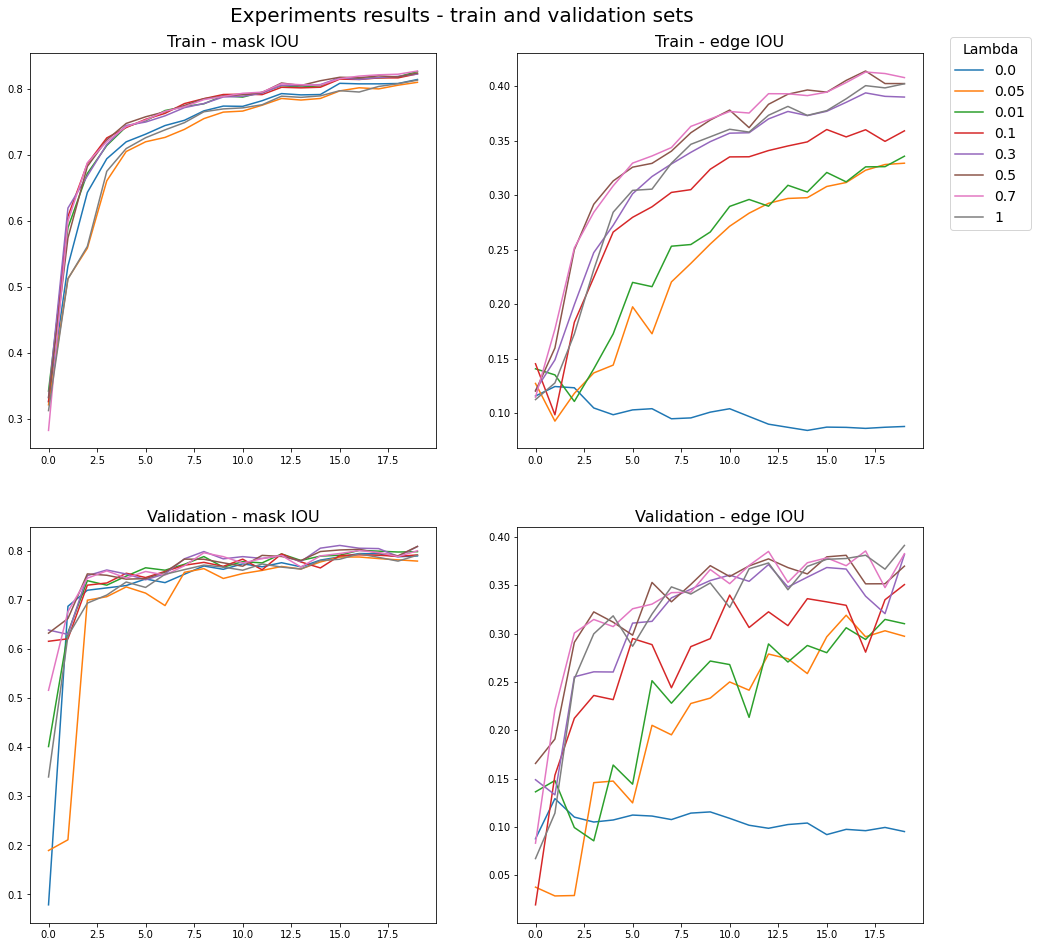

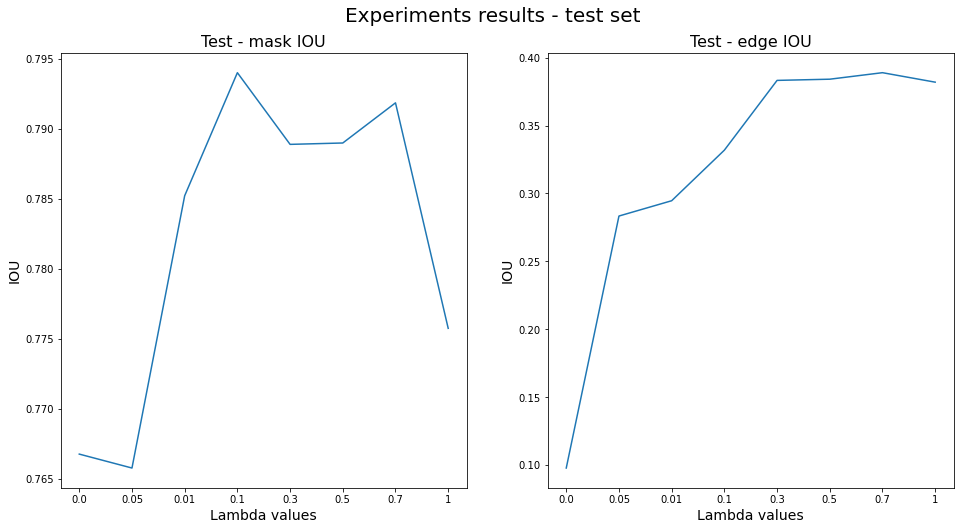

In [ ]:
task_ids = ['79aea44474da4792b6cd685c8cb8505e', '4f3fd7c20caa44ccb264eb4659b0b5d9', 
            'edeac1ea9aca406b82c089c3bcd96d2a', 'fc06ec3e24184ee992ac92c5b14ed4f0', 
            'b5fead95e55948a28713ed2a83cf813e', 'fb237a8a3e0c41b38d53e72efbf578bb', 
            'deeb93b66b5345e28b6bb096804fbaaa', '3433bd0e42a34b20bb89d5d3c2ffb91f']


def plot_results(data):
    fig, ((train_mask_iou, train_edge_iou), (val_mask_iou, val_edge_iou)) = plt.subplots(2, 2, figsize=(16, 16))
    fig.suptitle('Experiments results - train and validation sets', fontsize=20, y=0.92)
    train_mask_iou.set_title('Train - mask IOU', size=16)
    train_edge_iou.set_title('Train - edge IOU', size=16)
    val_mask_iou.set_title('Validation - mask IOU', size=16)
    val_edge_iou.set_title('Validation - edge IOU', size=16)

    for (config, scalars) in data:
        lambda_ = config['General/lambda']

        train_mask_iou_ = scalars['train']['mask_iou']['y']
        train_edge_iou_ = scalars['train']['edge_iou']['y']
        val_mask_iou_ = scalars['val']['mask_iou']['y']
        val_edge_iou_ = scalars['val']['edge_iou']['y']

        train_mask_iou.plot(train_mask_iou_, zorder=10, label=lambda_)
        train_edge_iou.plot(train_edge_iou_, zorder=10)
        val_mask_iou.plot(val_mask_iou_, zorder=10)
        val_edge_iou.plot(val_edge_iou_, zorder=10)

    fig.legend(title='Lambda', loc='upper right', bbox_to_anchor=(1, 0.9), title_fontsize=14, prop={'size': 14})
    plt.show()


    fig, (test_mask_iou, test_edge_iou) = plt.subplots(1, 2, figsize=(16, 8))
    fig.suptitle('Experiments results - test set', fontsize=20, y=0.96)
    test_mask_iou.set_title('Test - mask IOU', size=16)
    test_edge_iou.set_title('Test - edge IOU', size=16)

    test_mask_iou_ = [scalars['test']['mask_iou']['y'][0] for (_, scalars) in data]
    test_edge_iou_ = [scalars['test']['edge_iou']['y'][0] for (_, scalars) in data]
    lambdas = [config['General/lambda'] for (config, _) in data]

    test_mask_iou.set_xlabel('Lambda values', size=14)
    test_mask_iou.set_ylabel('IOU', size=14)
    test_edge_iou.set_xlabel('Lambda values', size=14)
    test_edge_iou.set_ylabel('IOU', size=14)

    test_mask_iou.plot(lambdas, test_mask_iou_, zorder=10)
    test_edge_iou.plot(lambdas, test_edge_iou_, zorder=10)
    plt.show()



plot_data = []
for task_id in task_ids:
    task = Task.get_task(task_id)
    config = task.get_parameters()
    scalars = task.get_reported_scalars()
    plot_data.append((config, scalars))

plot_results(plot_data)

#### IOU Threshold
I use different iou thresholds for mask and edge detection. The reason is that edge predictions are most of the time much "weaker" (values are closer to 0) than mask predictions and therefore need lower threshold. (It is very clearly visible on images below.)

#### IOU
Images below show 5 worst and 5 best edge IOU examples.

It seems that edge and mask results may be a little bit correlated i.e. when edge predictions are bad then sometimes mask predictions are also bad and the same for good predictions. 
(Especially that mean ious are: test_iou_loss=0.755, test_edge_iou=0.328)

Worst edge iou: [0.11157895 0.17494357 0.20708446 0.21068703 0.22142857]
Mask iou      : [0.77763575 0.7938574  0.71048516 0.69044584 0.507948  ]


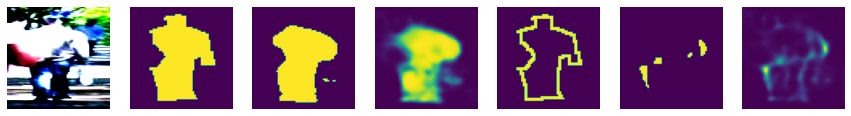

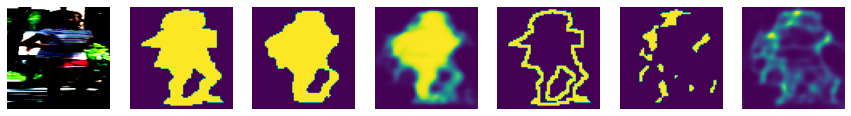

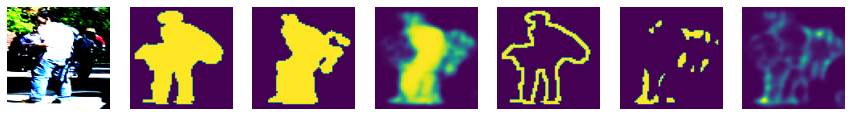

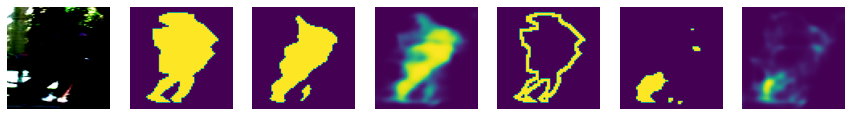

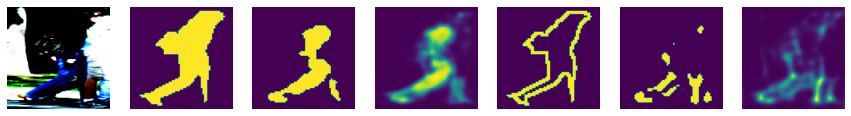

Best edge iou: [0.42155817 0.42483026 0.4561753  0.4261745  0.431946  ]
Mask iou     : [0.7741726  0.7281444  0.76578736 0.8891328  0.8867331 ]


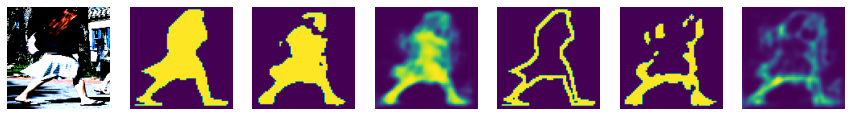

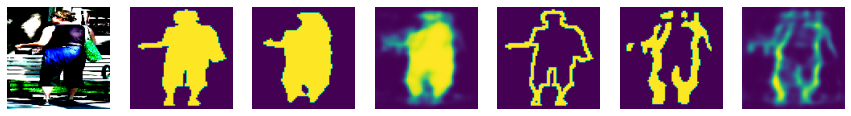

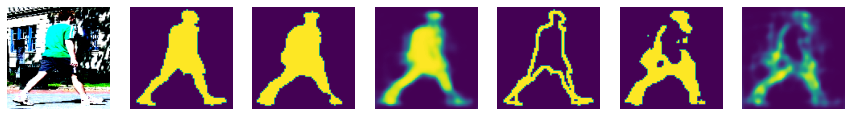

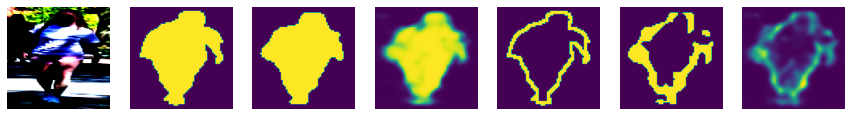

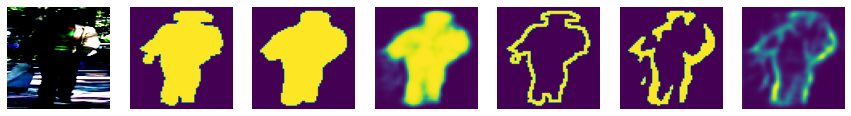

In [ ]:
test_mask_ious = ious(masks, masks_pred, threshold=EDGE_IOU_THRESHOLD)
test_mask_ious = test_mask_ious.cpu().detach().numpy()
test_edge_ious = ious(edges, edges_pred, threshold=EDGE_IOU_THRESHOLD)
test_edge_ious = test_edge_ious.cpu().detach().numpy()
k = 5
min_idxs = np.argpartition(test_edge_ious, k)[:k]
max_idxs = np.argpartition(test_edge_ious, -k)[-k:]

print(f'Worst edge iou: {test_edge_ious[min_idxs]}')
print(f'Mask iou      : {test_mask_ious[min_idxs]}')
print_results(images[min_idxs], masks[min_idxs], edges[min_idxs], masks_pred[min_idxs], edges_pred[min_idxs])

print(f'Best edge iou: {test_edge_ious[max_idxs]}')
print(f'Mask iou     : {test_mask_ious[max_idxs]}')
print_results(images[max_idxs], masks[max_idxs], edges[max_idxs], masks_pred[max_idxs], edges_pred[max_idxs])